In [ ]:
# Comparison
# Receiver Operating Characterisc curve

In [8]:
# Logistic Regression

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

dataset = pd.read_csv('riceclass.csv')
X = dataset.drop(['Class', 'id'], axis=1)
y = dataset['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# MODEL - LogisticRegression
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred, average='weighted')
recall = metrics.recall_score(y_test, y_pred, average='weighted')


In [1]:
# KNN

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# Load Dataset
dataset = pd.read_csv("riceclass.csv")

X = dataset.drop("Class", axis = 1)
X = X.drop("id", axis = 1)
y = dataset["Class"]

scaler = MinMaxScaler(feature_range = (0, 1))
X_rescaled = scaler.fit_transform(X)
X = pd.DataFrame(data = X_rescaled, columns = X.columns)

set_of_classes = y.value_counts().index.tolist()
set_of_classes = pd.DataFrame({"Class": set_of_classes})
y = pd.get_dummies(y)

# Split Dataset
data_train, data_test, class_train, class_test = train_test_split(X, y, test_size = 0.2, random_state = 21)

k = 63

knn_63 = KNeighborsClassifier(k)

knn_63.fit(data_train, class_train)

y_pred_63 = knn_63.predict(data_test)

print("Accuracy with k = 63 for full model: ", accuracy_score(class_test, y_pred_63) * 100)




Accuracy with k = 63 for full model:  93.56955380577428


In [23]:
# Neural Network

import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score

df = pd.read_csv("riceclass.csv")

df_input = df.drop(["id", "Class"], axis = 1)
df_output = df["Class"]

scale = MinMaxScaler(feature_range=(0, 1))
input_rescale = scale.fit_transform(df_input)
df_input = pd.DataFrame(data = input_rescale, columns = df_input.columns)

df_output = pd.get_dummies(df_output, dtype = int)

input_train, input_test, output_train, output_test = train_test_split(df_input, df_output, test_size=0.2)
mlp = MLPClassifier(solver = 'adam', random_state = 42, activation = 'logistic', learning_rate_init = 0.01, batch_size = 300, hidden_layer_sizes = (32, 128, 32,), max_iter = 1000)
mlp

mlp.fit(input_train, output_train)

predict = mlp.predict(input_test)
predict

param_grid = dict(
    learning_rate_init = [0.01, 0.001, 0.3, 0.1, 0.0001],
    solver = ['sgd','adam'],
    hidden_layer_sizes = [(128, 128, 128,), (32, 32,),(12,24,48,), (12,3), (32, 128, 32,)]
)
print("Accuracy: ", accuracy_score(output_test, predict))
print("Mean Square Error : ", mean_squared_error(output_test, predict))





Accuracy:  0.9330708661417323
Mean Square Error :  0.06692913385826772


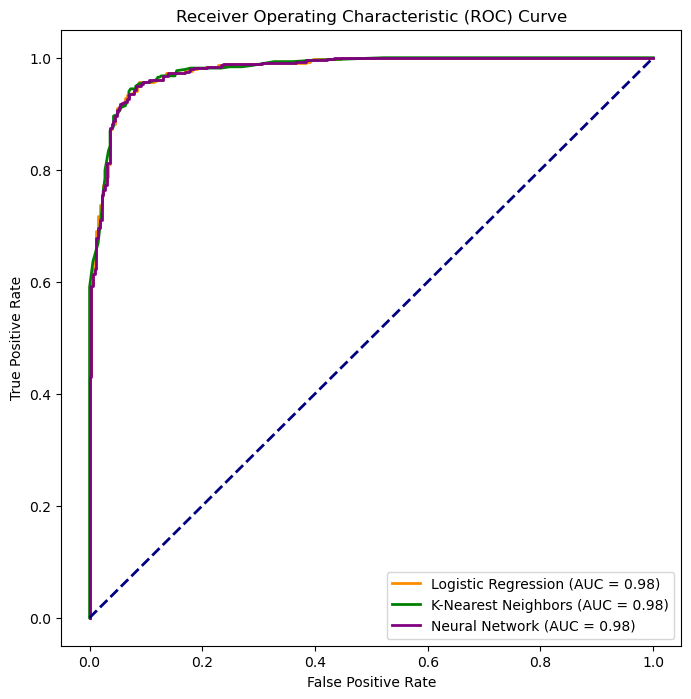

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt

# Load the data
dataset = pd.read_csv('riceclass.csv')
X = dataset.drop(['Class', 'id'], axis=1)
y = dataset['Class']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

# Standardize/Scale the data
scaler_lr = StandardScaler()
X_train_lr_scaled = scaler_lr.fit_transform(X_train)
X_test_lr_scaled = scaler_lr.transform(X_test)

scaler_knn = MinMaxScaler(feature_range=(0, 1))
X_train_knn_scaled = scaler_knn.fit_transform(X_train)
X_test_knn_scaled = scaler_knn.transform(X_test)

scaler_nn = MinMaxScaler(feature_range=(0, 1))
X_train_nn_scaled = scaler_nn.fit_transform(X_train)
X_test_nn_scaled = scaler_nn.transform(X_test)


# Encode labels for roc_curve
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)

# Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_lr_scaled, y_train)
logreg_probs = logreg.predict_proba(X_test_lr_scaled)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test_encoded, logreg_probs)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=63)  # Assuming 63 is the best k value from your tuning
knn.fit(X_train_knn_scaled, y_train)
knn_probs = knn.predict_proba(X_test_knn_scaled)[:, 1]
fpr_knn, tpr_knn, _ = roc_curve(y_test_encoded, knn_probs)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# Neural Network
mlp = MLPClassifier(solver = 'adam', random_state = 42, activation = 'logistic', learning_rate_init = 0.01, batch_size = 300, hidden_layer_sizes = (12, 24, 48,), max_iter = 1000)
mlp.fit(X_train_nn_scaled, y_train)
nn_probs = mlp.predict_proba(X_test_nn_scaled)[:, 1]
fpr_nn, tpr_nn, _ = roc_curve(y_test_encoded, nn_probs)
roc_auc_nn = auc(fpr_nn, tpr_nn)

# Plotting ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot(fpr_knn, tpr_knn, color='green', lw=2, label=f'K-Nearest Neighbors (AUC = {roc_auc_knn:.2f})')
plt.plot(fpr_nn, tpr_nn, color='purple', lw=2, label=f'Neural Network (AUC = {roc_auc_nn:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.neural_network import MLPClassifier
import torch
from torch import nn, optim
from skorch import NeuralNetClassifier
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Load the data
dataset = pd.read_csv('riceclass.csv')
X = dataset.drop(['Class', 'id'], axis=1)
y = dataset['Class']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

# Standardize/Scale the data
scaler_lr = StandardScaler()
X_train_lr_scaled = scaler_lr.fit_transform(X_train)
X_test_lr_scaled = scaler_lr.transform(X_test)

scaler_knn = MinMaxScaler(feature_range=(0, 1))
X_train_knn_scaled = scaler_knn.fit_transform(X_train)
X_test_knn_scaled = scaler_knn.transform(X_test)

# Encode labels for roc_curve
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)

# Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_lr_scaled, y_train)
y_pred_lr = logreg.predict(X_test_lr_scaled)
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)

accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr, average='weighted')
recall_lr = recall_score(y_test, y_pred_lr, average='weighted')
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')

# K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=63)  # Assuming 63 is the best k value from your tuning
knn.fit(X_train_knn_scaled, y_train)
y_pred_knn = knn.predict(X_test_knn_scaled)
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)

accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn, average='weighted')
recall_knn = recall_score(y_test, y_pred_knn, average='weighted')
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')

# Neural Network
device = "cuda" if torch.cuda.is_available() else "cpu"
input_size = X.shape[1]
hidden_layer_size = [12, 24, 48]
learning_rate = 0.01
amount_epochs = 1000

class NeuralNetwork(nn.Module):
    def __init__(self, input_val, hidden_layers):
        super().__init__()
        self.input = nn.Linear(input_val, hidden_layers[0]).to(torch.float32)
        self.hidden = nn.ModuleList([nn.Linear(hidden_layers[i], hidden_layers[i+1]).to(torch.float32) for i in range(len(hidden_layers) - 1)])
        self.output = nn.Linear(hidden_layers[-1], 1).to(torch.float32)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.input(x))
        for items in self.hidden:
            x = self.sigmoid(items(x))
        x = self.output(x)
        return x

model_nn = NeuralNetwork(input_size, hidden_layer_size)
optimizer_nn = optim.Adam(model_nn.parameters(), lr=learning_rate)
criterion_nn = nn.BCEWithLogitsLoss()

# Encode labels for neural network training
label_encoder_nn = LabelEncoder()
y_train_encoded_nn = label_encoder_nn.fit_transform(y_train)

X_train_nn = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
y_train_nn = torch.tensor(y_train_encoded_nn, dtype=torch.float32)
X_test_nn = torch.tensor(X_test.to_numpy(), dtype=torch.float32)

train_data_nn = TensorDataset(X_train_nn, y_train_nn)
train_loader_nn = DataLoader(train_data_nn, batch_size=300, shuffle=True)

for epoch in range(amount_epochs):
    for inputs, labels in train_loader_nn:
        optimizer_nn.zero_grad()
        outputs = model_nn(inputs)
        loss = criterion_nn(outputs, labels.view(-1, 1))
        loss.backward()
        optimizer_nn.step()

model_nn.eval()
with torch.no_grad():
    y_probs_nn = torch.sigmoid(model_nn(X_test_nn)).numpy()
y_pred_nn = torch.round(torch.sigmoid(model_nn(X_test_nn))).detach().numpy()
conf_matrix_nn = confusion_matrix(y_test_encoded, y_pred_nn)

accuracy_nn = accuracy_score(y_test_encoded, y_pred_nn)
precision_nn = precision_score(y_test_encoded, y_pred_nn, average='weighted')
recall_nn = recall_score(y_test_encoded, y_pred_nn, average='weighted')
f1_nn = f1_score(y_test_encoded, y_pred_nn, average='weighted')

# Print the results
print("Logistic Regression Confusion Matrix:")
print(conf_matrix_lr)
print("Accuracy: {:.4f}".format(accuracy_lr))
print("Precision: {:.4f}".format(precision_lr))
print("Recall: {:.4f}".format(recall_lr))
print("F1 Score: {:.4f}".format(f1_lr))
print()

print("K-Nearest Neighbors Confusion Matrix:")
print(conf_matrix_knn)
print("Accuracy: {:.4f}".format(accuracy_knn))
print("Precision: {:.4f}".format(precision_knn))
print("Recall: {:.4f}".format(recall_knn))
print("F1 Score: {:.4f}".format(f1_knn))
print()

print("Neural Network Confusion Matrix:")
print(conf_matrix_nn)
print("Accuracy: {:.4f}".format(accuracy_nn))
print("Precision: {:.4f}".format(precision_nn))
print("Recall: {:.4f}".format(recall_nn))
print("F1 Score: {:.4f}".format(f1_nn))

Logistic Regression Confusion Matrix:
[[302  28]
 [ 22 410]]
Accuracy: 0.9344
Precision: 0.9344
Recall: 0.9344
F1 Score: 0.9343

K-Nearest Neighbors Confusion Matrix:
[[303  27]
 [ 22 410]]
Accuracy: 0.9357
Precision: 0.9357
Recall: 0.9357
F1 Score: 0.9356

Neural Network Confusion Matrix:
[[  0 330]
 [  0 432]]
Accuracy: 0.5669
Precision: 0.3214
Recall: 0.5669
F1 Score: 0.4102


/Users/yinkuntang/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
